In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

import gzip
import shutil
import json
import os

from pyspark import SparkContext, SparkConf
import re

In [3]:
from ineqpy import atkinson,gini,percentile

## Reading different statistics from per taxi metrics

Adding `run_id` to the dictionary of results.

In [4]:
def add_run_id(fname, d, mode="per_taxi"):
    """
    Given the long filename from Spark, and a dict, this function
    cuts out the run_id from the filename, and adds it with a key
    `run_id` to the dictionary d.
    """
    if mode=="per_taxi":
        d["run_id"] = re.sub('^run_','',re.sub("_per_taxi_metrics.json.gz$",'',fname.split('/')[-1]))
    elif mode=="aggregates":
        d["run_id"] = re.sub('^run_','',re.sub("_aggregates.csv.gz$",'',fname.split('/')[-1]))
    return d

Here, we could calculate everything we need from the incomes, online ratios etc. at once.

In [12]:
def calculate_ratio(data,thres=20):
    upper_thres = np.percentile(data,100-thres)
    lower_thres = np.percentile(data,thres)
    
    upper_mean = np.mean(data[np.where(data>upper_thres)])
    lower_mean = np.mean(data[np.where(data>lower_thres)])
    
    return upper_mean/lower_mean

In [6]:
def calc_inequality_indices(t):
    """
    Given a dictionary with the results, it calculates the different inequality indices
    of the incomes.
    """
    if "trip_avg_price" in t:
        p = np.array(list(map(float,t["trip_avg_price"])))
    elif "trip_income" in t:
        p=np.array(list(map(float,t["trip_income"])))
    else:
        return {
            "run_id" : t["run_id"],
            "atkinson" : None,
            "gini" : None,
            "20/20_ratio" : None
        
        }
    
    return {
        "run_id" : t["run_id"],
        "atkinson" : atkinson(p),
        "gini" : gini(p),
        "20/20_ratio" : calculate_ratio(p)
    }

In [8]:
os.environ["SPARK_HOME"] = "/home/bokanyie/spark-2.3.0-bin-hadoop2.7/"
os.environ["PYSPARK_PYTHON"] = "/home/bokanyie/anaconda/envs/py36/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON "] = "/home/bokanyie/anaconda/envs/py36/bin/python"

In [9]:
# Spark settings
conf = SparkConf().set("spark.executor.memory", "20g")

# removing old output directory
if "ineq_indices" in os.listdir('.'):
    shutil.rmtree("ineq_indices")

In [10]:
# initializing a SparkContext object
sc = SparkContext(conf=conf)

In [ ]:
ineq_df = pd.DataFrame.from_dict(sc.wholeTextFiles('../results/run_2019*_per_taxi_metrics.json.gz')\
.map(lambda t: add_run_id(t[0],json.loads(t[1].split('\n')[-2])))\
.map(lambda t: calc_inequality_indices(t))\
.collect())

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

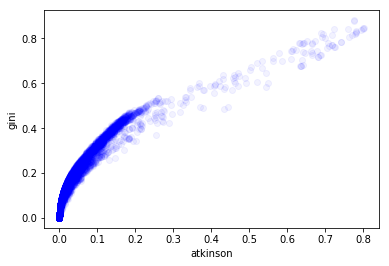

In [20]:
plt.plot(ineq_df['atkinson'],ineq_df['gini'],'bo',alpha=0.05)
plt.xlabel('atkinson')
plt.ylabel('gini')

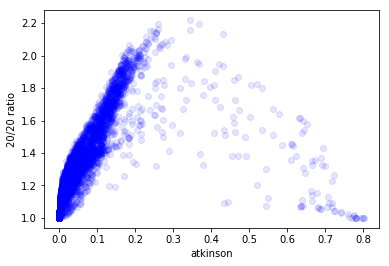

In [21]:
plt.plot(ineq_df['atkinson'],ineq_df['20/20_ratio'],'bo',alpha=0.1)
plt.xlabel('atkinson')
plt.ylabel('20/20 ratio')

## Reading the configuration data

In [23]:
configs = []
with gzip.open('../configs/2019_all.conf.gz') as f:
    for line in f.readlines():
        configs.append(json.loads(line))

configs_df = pd.DataFrame.from_dict(configs)

## Reading the aggregate csv files

In [31]:
# removing old output directory
if "temp_data" in os.listdir():
    if "aggregates" in os.listdir("temp_data"):
        shutil.rmtree("temp_data/aggregates")
else:
    print("Make a temp_data directory!")

In [ ]:
# initializing a SparkContext object
sc = SparkContext(conf=conf)

In [32]:
# defining a Spark RDD and saving the results into a textfile
sc.wholeTextFiles('../results/run_2019*.csv.gz')\
.map(lambda t: add_run_id(t[0],pd.DataFrame.from_csv(t[0]).iloc[-1,].to_dict(),mode="aggregates"))\
.saveAsTextFile("temp_data/aggregates")

In [33]:
# stopping the SparkContext
sc.stop()

Somehow I could not find a solution in Python, so here is a first small preparation in bash.

In [34]:
%%bash 

cat temp_data/aggregates/part* | sed 's/\x27/\"/g' | sed 's/nan/null/g' | grep -v '{79.0:' | jq -c '.' > aggregates.json

In [35]:
# collecting results from Spark
aggregates_df  = pd.DataFrame.from_dict(
    [
        json.loads(l.strip('\n')) for l in open('aggregates.json').readlines()
    ]
)

## Merging and cleaning the joined results

In [ ]:
# setting run_ids as index for all three dataframes
configs_df['run_id'] = configs_df['run_id'].map(lambda s: re.sub('\.conf','',s))
configs_df.set_index('run_id',inplace=True)

In [39]:
ineq_df.set_index('run_id',inplace=True)
aggregates_df.set_index('run_id',inplace=True)

In [41]:
# joining the different results
merged = configs_df.join(ineq_df).join(aggregates_df,rsuffix="_2")

# dropping one row that belongs to the base config
merged.drop('2019_02_14_base',inplace=True)
# adding a geom column from the run_ids
merged["geom"]=merged.index.map(lambda s: re.sub(r'^.+geom_([0-9]).+$',r'\1',s))

def select_not_nan(x,y):
    """
    Out of two elements, returns the one that is not a pandas NaN.
    If both are NaNs, returns a NaN.
    """
    if pd.isnull(x):
        return y
    else:
        return x

# merging names from old and new code to one single column
for prefix in ['avg', 'std']:
    merged[prefix+'_trip_avg_price'] = merged[prefix+'_trip_avg_price'].combine(merged[prefix+'_trip_income'],select_not_nan)
    merged.drop(prefix+'_trip_income',axis=1,inplace=True)

In [42]:
# deleting unnecessary columns
merged.drop([
    "show_plot", 
    "show_map_labels", 
    "show_pending", 
    "avg_timestamp", 
    "std_timestamp",
    "0",
    "avg_request_lengths_2"
],axis=1,inplace=True)

In [43]:
# saving results
merged.to_csv('results.csv.gz',compression='gzip')

In [45]:
merged.head().T

run_id,2019_02_14_base_d_120_R_0_05_alg_nearest_geom_0_behav_go_back_ic_base_reset_false,2019_02_14_base_d_120_R_0_05_alg_nearest_geom_0_behav_stay_ic_base_reset_false,2019_02_14_base_d_120_R_0_05_alg_nearest_geom_0_behav_stay_ic_home_reset_false,2019_02_14_base_d_120_R_0_05_alg_nearest_geom_0_behav_stay_ic_home_reset_true,2019_02_14_base_d_120_R_0_05_alg_nearest_geom_1_behav_go_back_ic_base_reset_false
R,0.05,0.05,0.05,0.05,0.05
avg_request_lengths,20.1,20.1,20.1,20.1,24.9
base_coords,"[20, 20]","[20, 20]","[20, 20]","[20, 20]","[20, 20]"
batch_size,180,180,180,180,180
behaviour,go_back,stay,stay,stay,go_back
cost_per_unit,13,13,13,13,13
d,120,120,120,120,120
hard_limit,10,10,10,10,10
initial_conditions,base,base,home,home,base
log,False,False,False,False,False
